## PipaFinder Mainframe
## Previsão com Modelo de Regressão Linear

In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

In [2]:
simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [19]:
# Carrega os dados
dados = pd.read_csv("./CSV/ColBroker.csv")
dados['DATA'] = pd.to_datetime(dados.DATA_HORA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dados.rename(columns={'DATA': 'Data'}, inplace=True)
#dados.rename(columns={'LEITURAFILESYSTEM': 'Filesystem'}, inplace=True)
dados.drop(columns=['_id','DATA_HORA'], inplace=True)
dados = dados[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dados.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)
dados = dados.set_index('Data')
dados

,Broker,Service_name,Service_class,Programa,Quantidade
Data,,,,,
2022-10-20 00:05:00,ETB170,PORTALDETRAN,SDGX,NSDGXCE5,1
2022-10-20 00:05:00,ETB170,PORTALDETRAN,SDGX,NSDGXCNH,3
2022-10-20 00:05:00,ETB170,PORTALDETRAN,SDGX,NSDGXCPO,3
2022-10-20 00:05:00,ETB170,PORTALDETRAN,SDGX,NSDGXEN1,1
2022-10-20 00:05:00,ETB170,PORTALDETRAN,SDGX,NSDGXS0C,1
...,...,...,...,...,...
2022-10-25 11:28:00,ETB160,PORTALDETRAN,SDGX,NSS06WS4,9
2022-10-25 11:28:00,ETB160,SIDSB,SXA2,NSSAFG69,99
2022-10-25 11:28:00,ETB160,SIDSB,SXA2,NSXA2A02,114


In [7]:
# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 
dados.drop_duplicates(subset='Data', inplace=True)
dados = dados.set_index('Data')
dados = dados.resample('D').interpolate()

In [8]:
dados = dados.to_period()

In [20]:
# Dados Completos - out/21

df=dados.copy()
df

,Filesystem
Data,
2021-10-13,32.01
2021-10-14,32.01
2021-10-15,32.02
2021-10-16,32.02
2021-10-17,32.03
...,...
2022-10-07,72.93
2022-10-08,73.05
2022-10-09,73.17


In [20]:
# Carrega os dados
dados = pd.read_csv("Capacidade_VM53245_barra_2.csv")
dados['DATA'] = pd.to_datetime(dados.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dados['DATA'] = pd.to_datetime(dados['DATA']).dt.date
dados['DATA'] = pd.to_datetime(dados.DATA, format = '%Y-%m-%d')
dados.rename(columns={'DATA': 'Data'}, inplace=True)
dados.rename(columns={'LEITURAFILESYSTEM': 'Filesystem'}, inplace=True)
dados.drop(columns=['IP','alimenta', 'HOSTNAME', 'TIMESTAMP', '_id', 'IDENTIFICACAO', 'FILESYSTEM'], inplace=True)

In [21]:
# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 
dados.drop_duplicates(subset='Data', inplace=True)
dados = dados.set_index('Data')
dados = dados.resample('D').interpolate()

In [22]:
dados = dados.to_period()

In [23]:
# Dados Completos - out/21  até 19/10/22

df=dados.copy()
df

,Filesystem
Data,
2021-10-22,32.070
2021-10-23,32.080
2021-10-24,32.085
2021-10-25,32.090
2021-10-26,32.100
...,...
2022-10-16,75.210
2022-10-17,75.500
2022-10-18,75.790


In [22]:
# Dados Parciais - mar/22

df=df[168:]
df

,Filesystem
Data,
2022-03-30,43.440
2022-03-31,44.635
2022-04-01,45.830
2022-04-02,45.870
2022-04-03,45.900
...,...
2022-10-07,72.930
2022-10-08,73.050
2022-10-09,73.170


In [3]:
# Carrega os dados
dados = pd.read_csv("Capacidade_VM53245_barra.csv")
dados['DATA'] = pd.to_datetime(dados.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dados['DATA'] = pd.to_datetime(dados['DATA']).dt.date
dados['DATA'] = pd.to_datetime(dados.DATA, format = '%Y-%m-%d')
dados.rename(columns={'DATA': 'Data'}, inplace=True)
dados.rename(columns={'LEITURAFILESYSTEM': 'Filesystem'}, inplace=True)
dados.drop(columns=['IP','alimenta', 'HOSTNAME', 'TIMESTAMP', '_id', 'IDENTIFICACAO', 'FILESYSTEM'], inplace=True)

In [4]:
# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 
dados.drop_duplicates(subset='Data', inplace=True)
dados = dados.set_index('Data')
dados = dados.resample('D').interpolate()

In [5]:
dados = dados.to_period()

In [7]:
# Dados Completos - out/21

df=dados.copy()
df

,Filesystem
Data,
2021-10-13,32.01
2021-10-14,32.01
2021-10-15,32.02
2021-10-16,32.02
2021-10-17,32.03
...,...
2022-10-07,72.93
2022-10-08,73.05
2022-10-09,73.17


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 364 entries, 2021-10-13 to 2022-10-11
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Filesystem  364 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [3]:
# Dados dos últimos 30 dias - set/22

# Carrega os df
dados = pd.read_csv("Capacidade_VM53245_barra_igual_web.csv", parse_dates=["Data"])
dados = dados.set_index('Data')
dados = dados.to_period()

In [4]:
# Dados dos últimos 30 dias - set/22

df=dados.copy()
df

,Filesystem
Data,
2022-09-12,57.89
2022-09-13,57.73
2022-09-14,59.21
2022-09-15,60.70
2022-09-16,65.03
2022-09-17,63.96
2022-09-18,64.06
2022-09-19,64.06
2022-09-20,67.97


<AxesSubplot:xlabel='Data'>

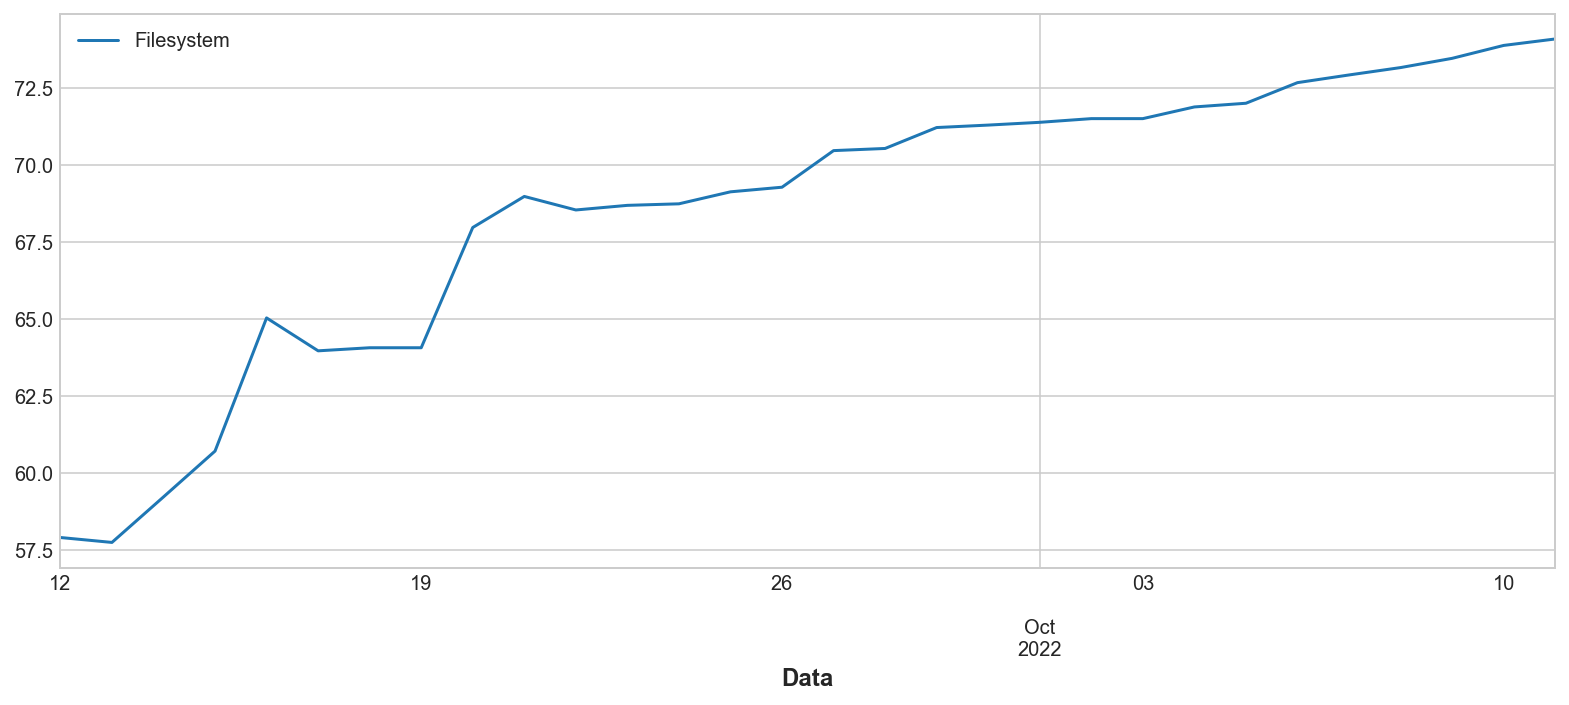

In [5]:
# Dados dos últimos 30 dias - set/22

df.plot()

In [10]:
# Dados dos últimos 30 dias - de 20/set/22 até 11/out/22 

# Carrega os df
dados = pd.read_csv("Capacidade_VM53245_barra_igual_web_2.csv", parse_dates=["Data"])
dados = dados.set_index('Data')
dados = dados.to_period()

In [11]:
# Dados dos últimos 30 dias - de 20/set/22 até 11/out/22 

df=dados.copy()
df

,Filesystem
Data,
2022-09-20,67.97
2022-09-21,68.98
2022-09-22,68.54
2022-09-23,68.69
2022-09-24,68.74
2022-09-25,69.13
2022-09-26,69.28
2022-09-27,70.47
2022-09-28,70.54


<AxesSubplot:xlabel='Data'>

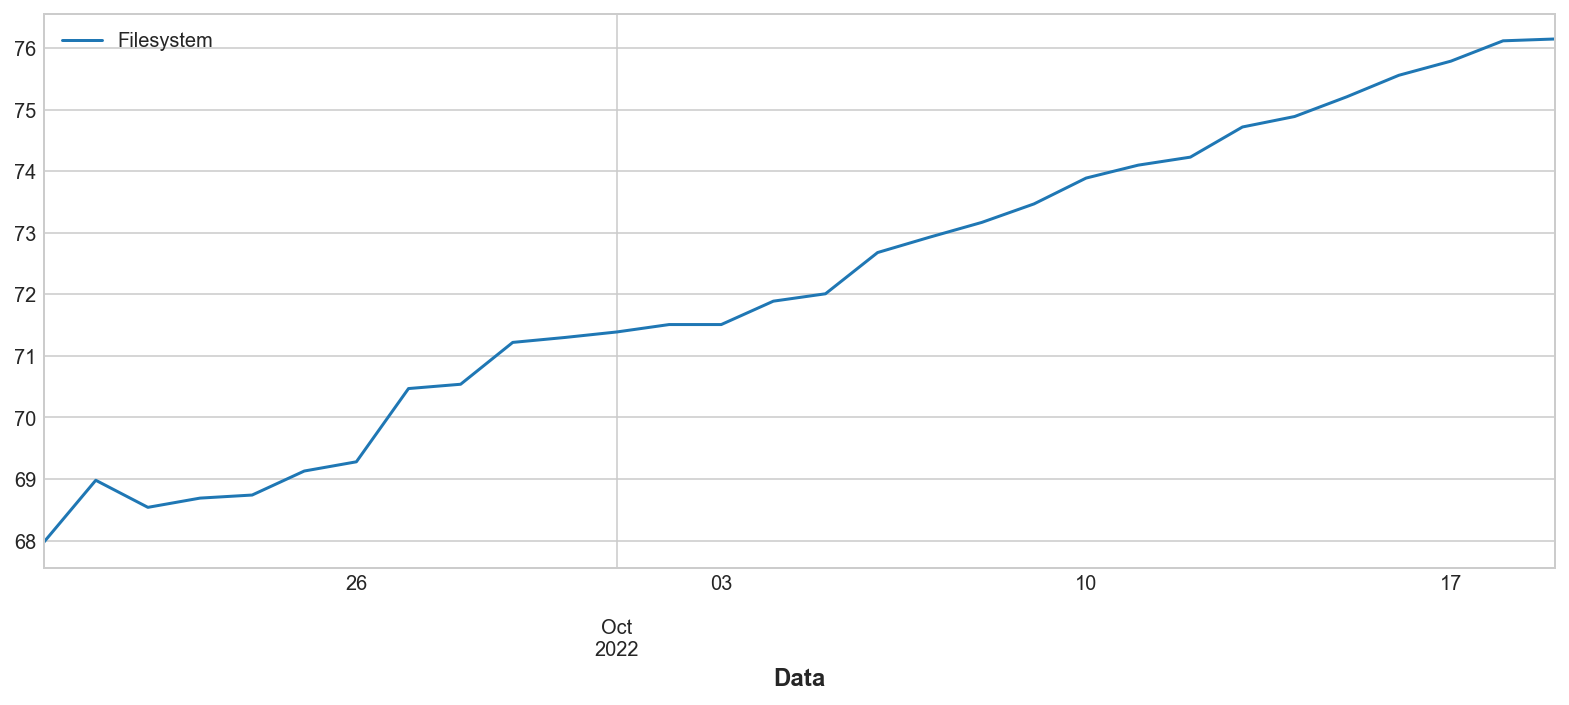

In [12]:
# Dados dos últimos 30 dias - de 20/set/22 até 11/out/22 

df.plot()

<AxesSubplot:xlabel='Data'>

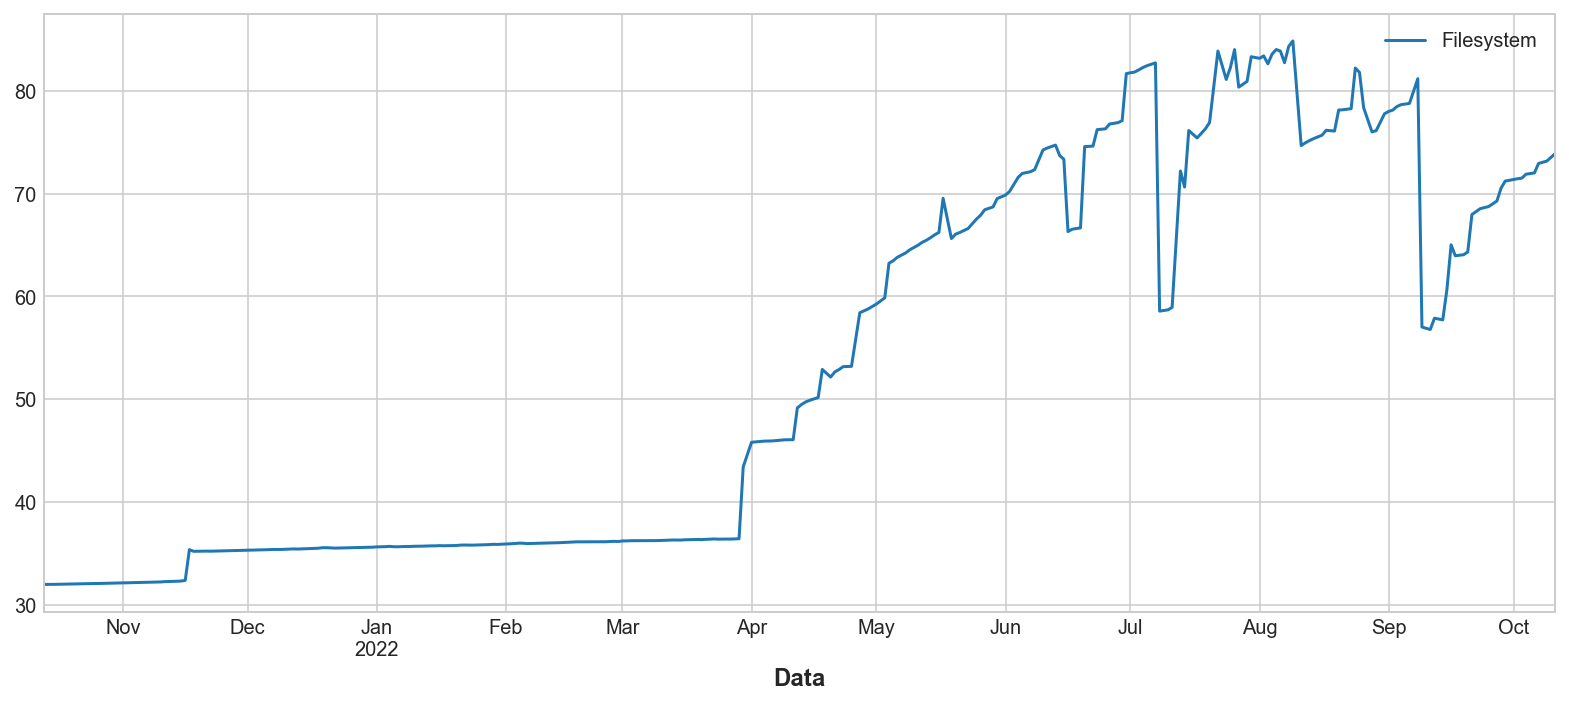

In [9]:
# Dados Completos - out/21

df.plot()

<AxesSubplot:xlabel='Data'>

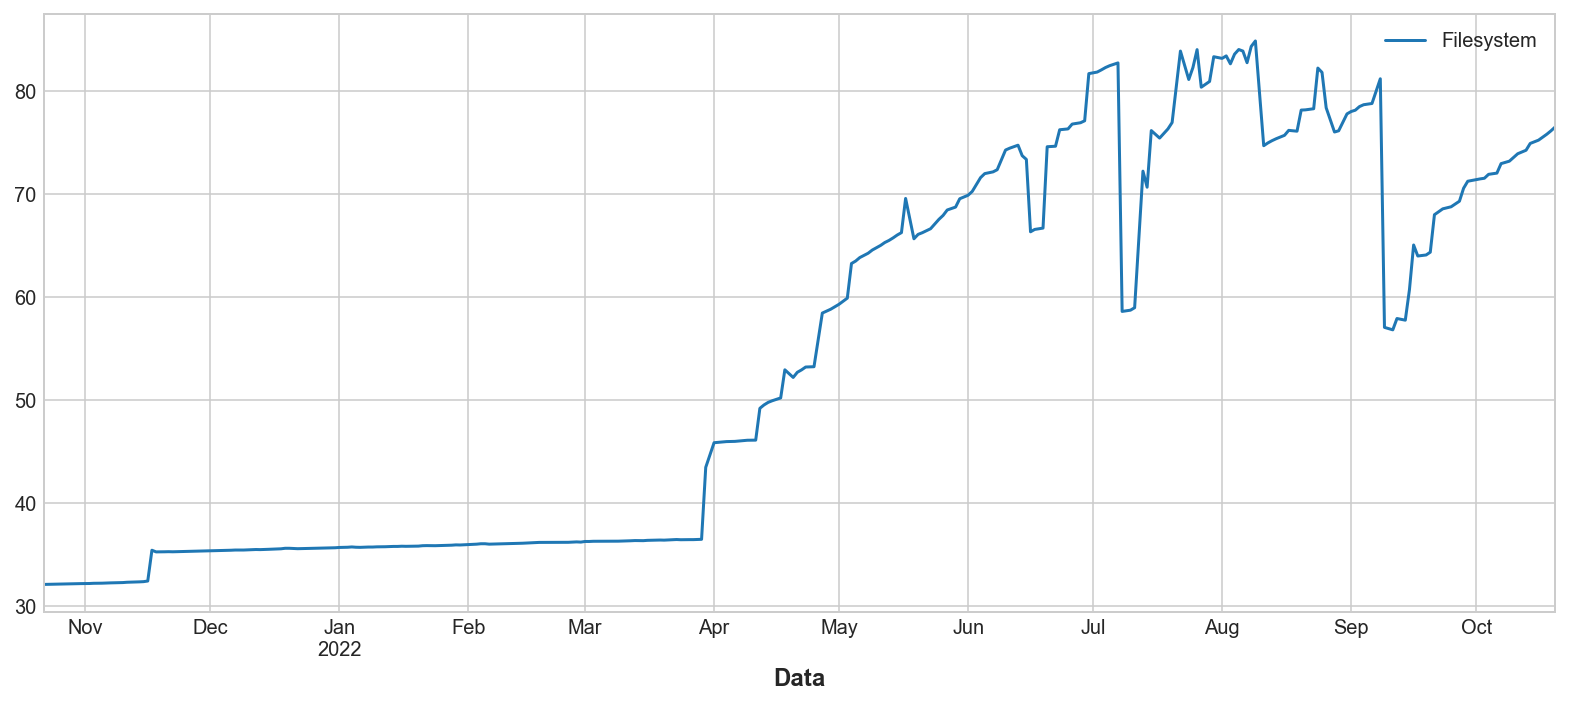

In [25]:
# Dados Completos - out/21  até 19/10/22

df.plot()

<AxesSubplot:xlabel='Data'>

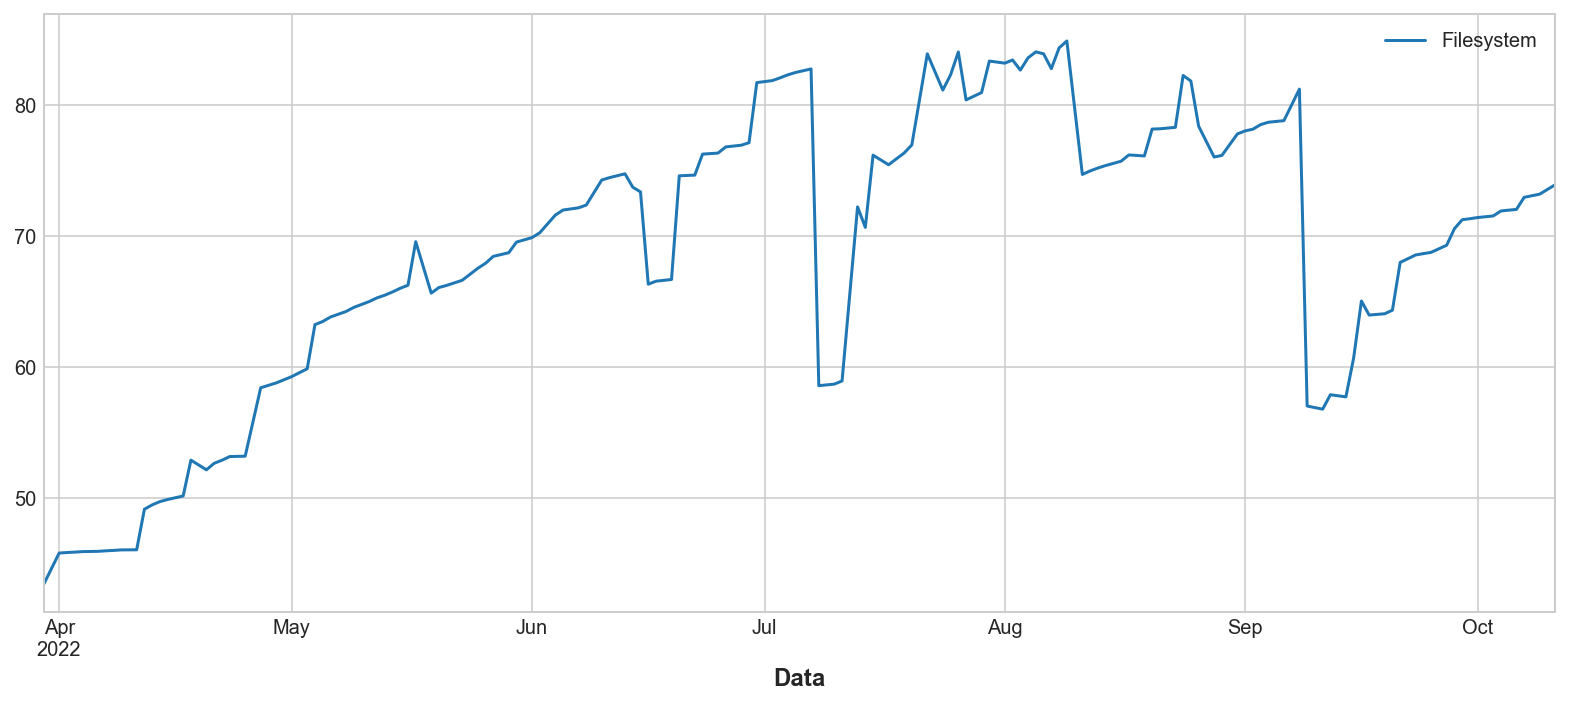

In [23]:
# Dados Parciais - mar/22

df.plot()

In [24]:
dp = DeterministicProcess(index=df.index, constant=True, order=1, drop=True,)
X = dp.in_sample()
X.head()

,const,trend
Data,,
2022-03-30,1.0,1.0
2022-03-31,1.0,2.0
2022-04-01,1.0,3.0
2022-04-02,1.0,4.0
2022-04-03,1.0,5.0


In [25]:
y = df["Filesystem"]  
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

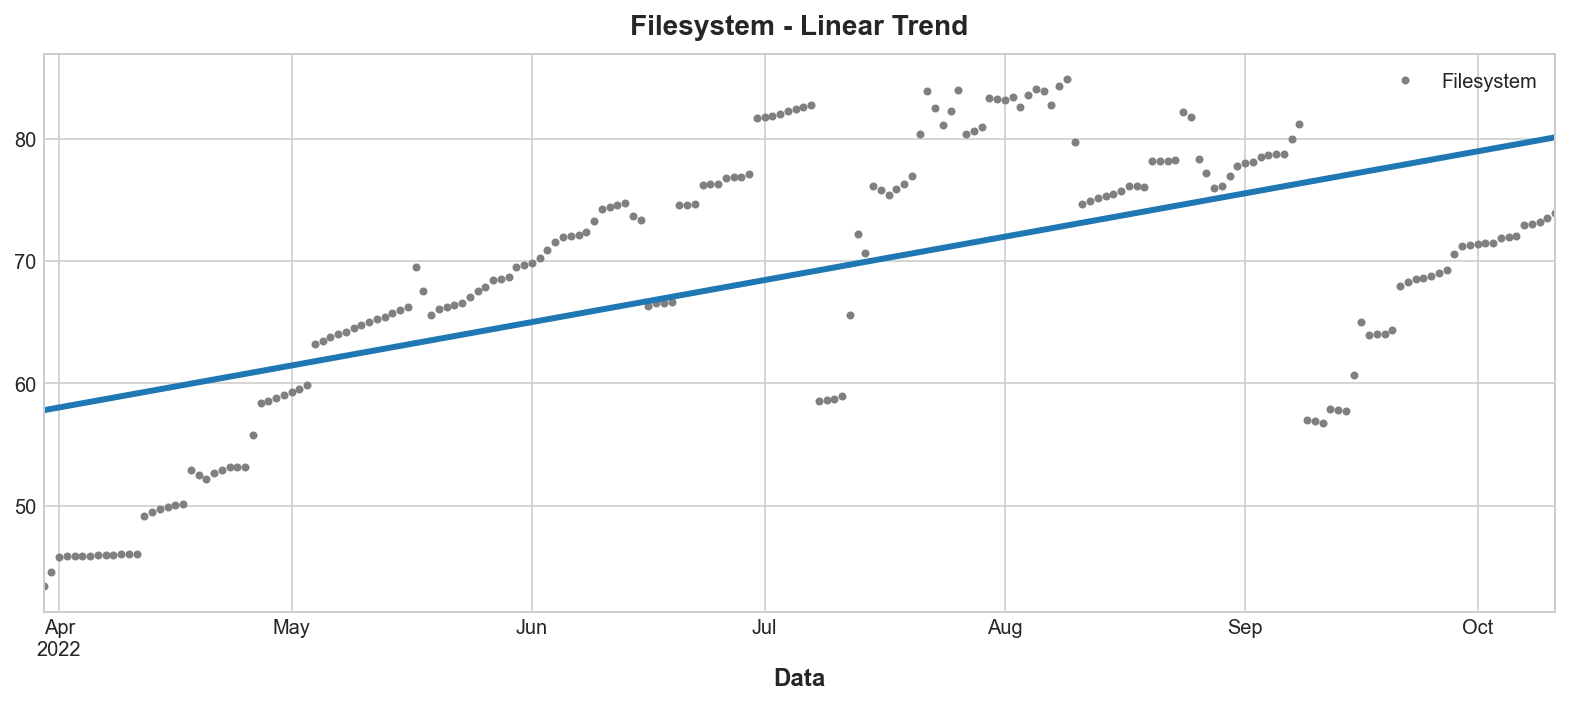

In [26]:
# Dados Parciais - mar/22

ax = df.plot(style=".", color="0.5", title="Filesystem - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [10]:
dp = DeterministicProcess(index=df.index, constant=True, order=1, drop=True,)
X = dp.in_sample()
X.head()

,const,trend
Data,,
2021-10-13,1.0,1.0
2021-10-14,1.0,2.0
2021-10-15,1.0,3.0
2021-10-16,1.0,4.0
2021-10-17,1.0,5.0


In [11]:
y = df["Filesystem"]  
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

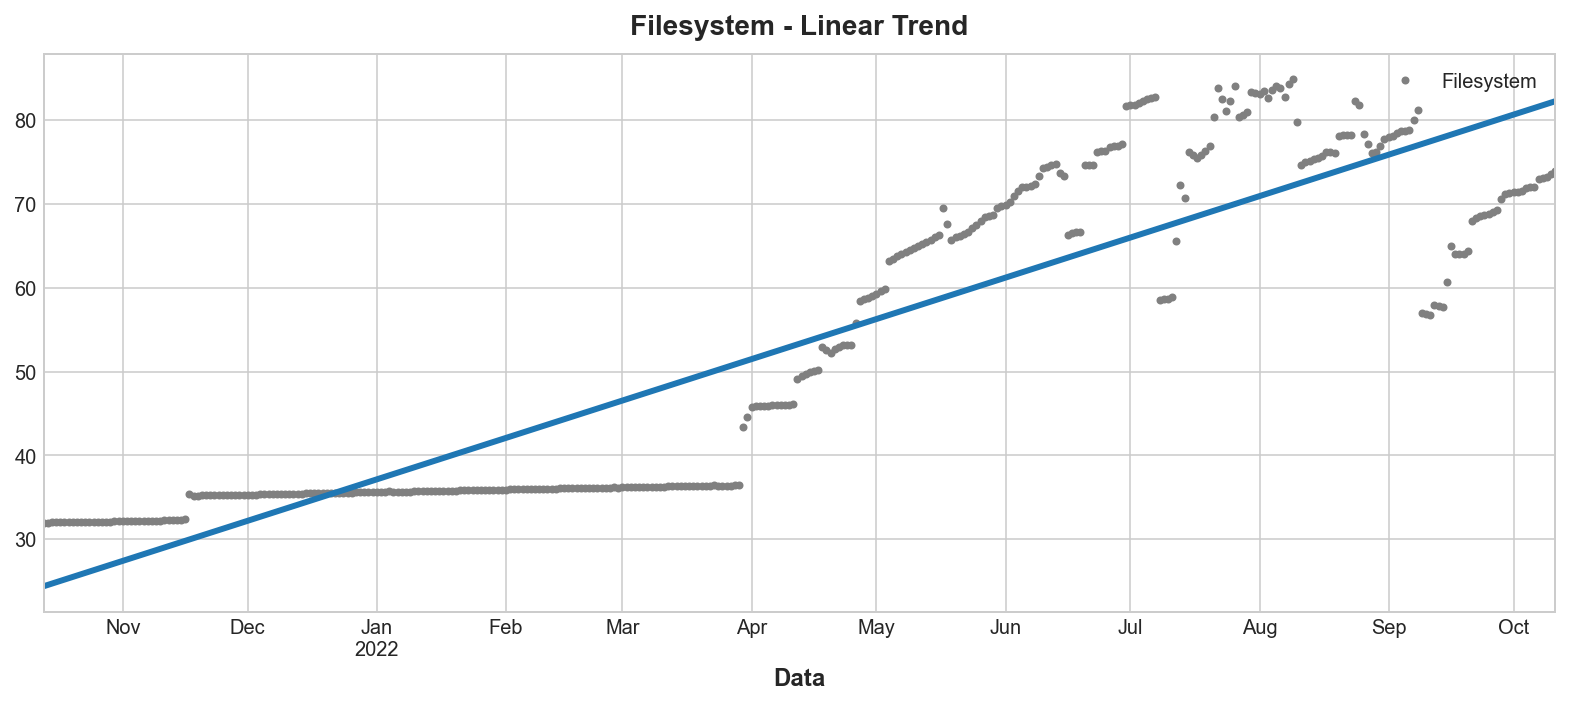

In [12]:
# Dados Completos - out/21

ax = df.plot(style=".", color="0.5", title="Filesystem - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [13]:
# Dados dos últimos 30 dias - de 20/set/22 até 11/out/22 

dp = DeterministicProcess(index=df.index, constant=True, order=1, drop=True,)
X = dp.in_sample()
X.head()

,const,trend
Data,,
2022-09-20,1.0,1.0
2022-09-21,1.0,2.0
2022-09-22,1.0,3.0
2022-09-23,1.0,4.0
2022-09-24,1.0,5.0


In [14]:
# Dados dos últimos 30 dias - de 20/set/22 até 11/out/22 

y = df["Filesystem"]  
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

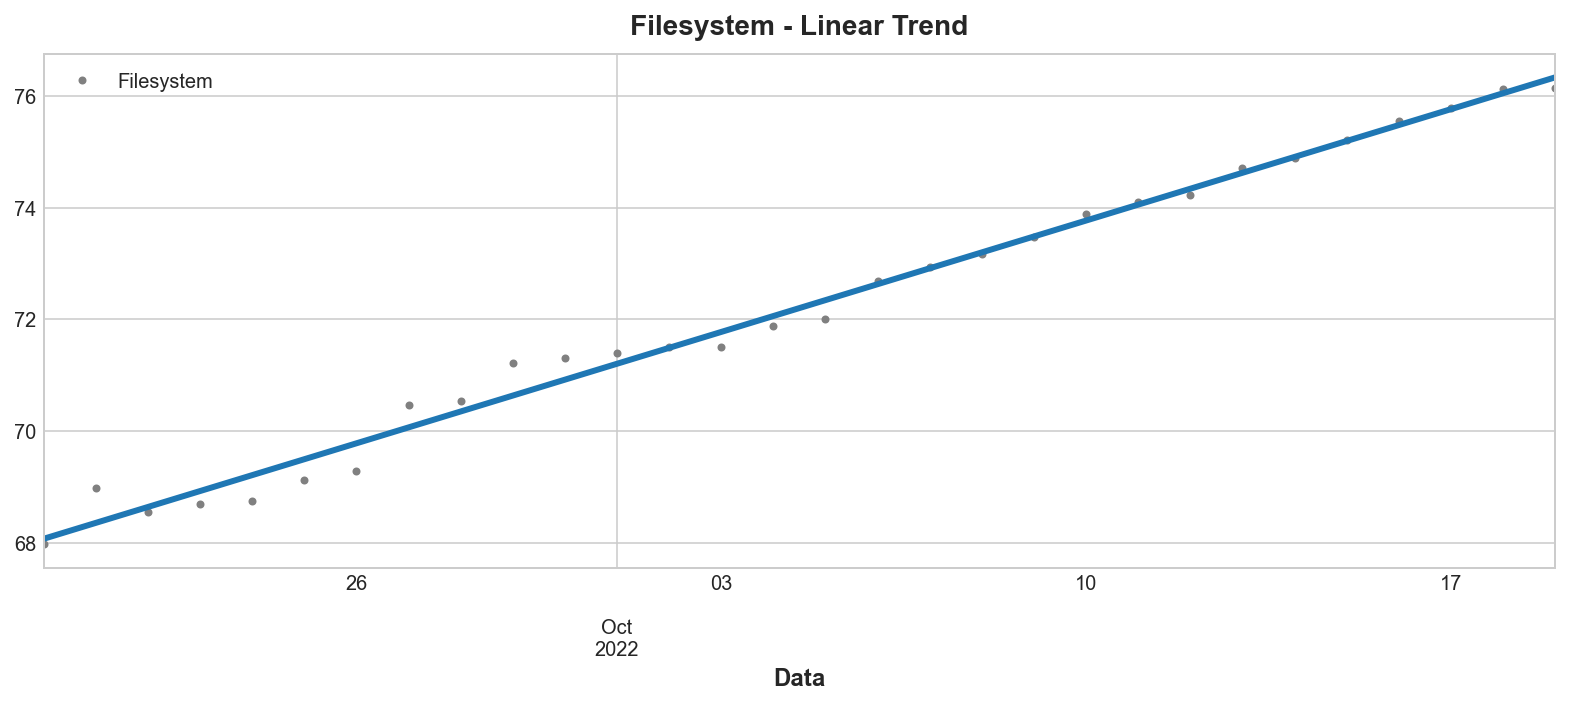

In [15]:
# Dados dos últimos 30 dias - de 20/set/22 até 11/out/22 

ax = df.plot(style=".", color="0.5", title="Filesystem - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

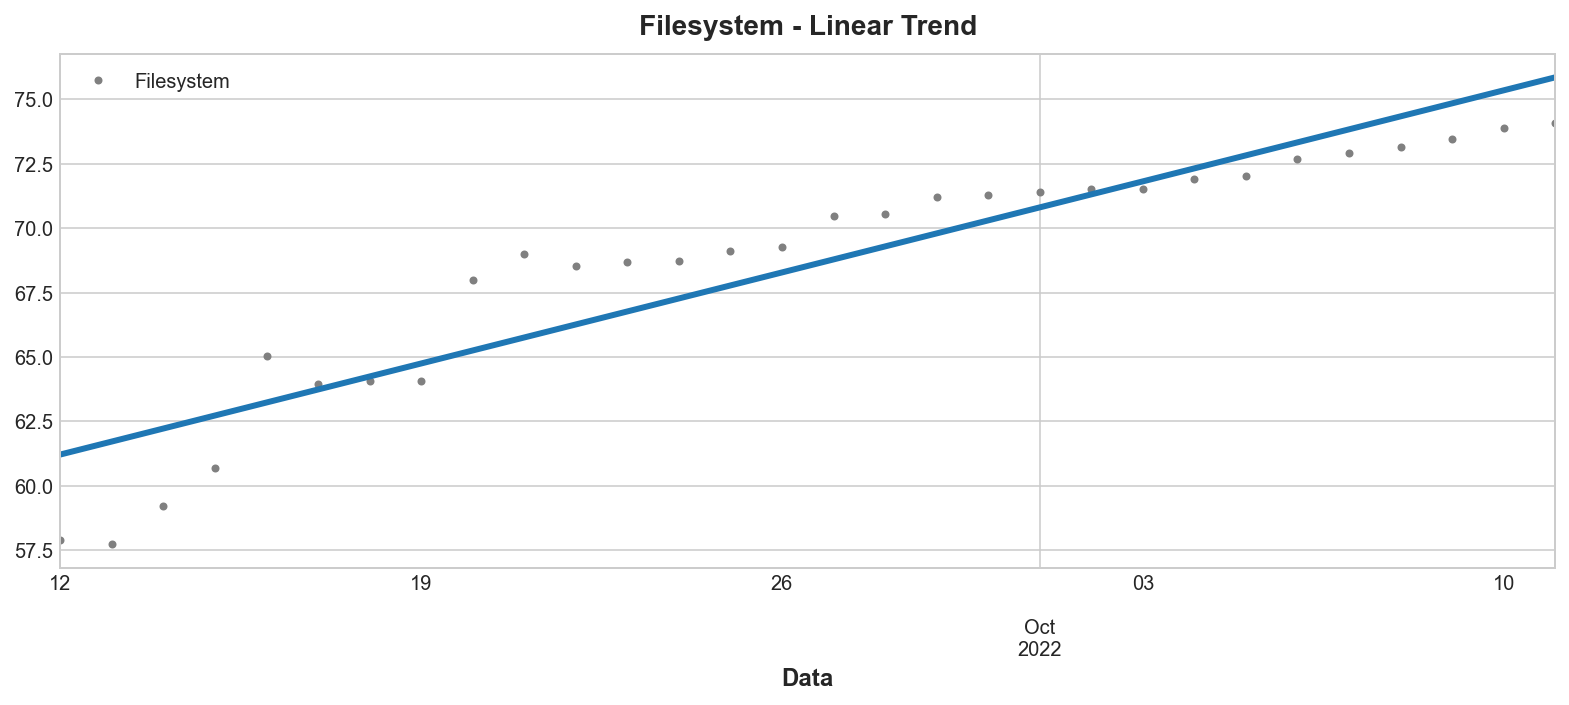

In [8]:
# Dados dos últimos 30 dias - set/22

ax = df.plot(style=".", color="0.5", title="Filesystem - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [27]:
X = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X), index=X.index)

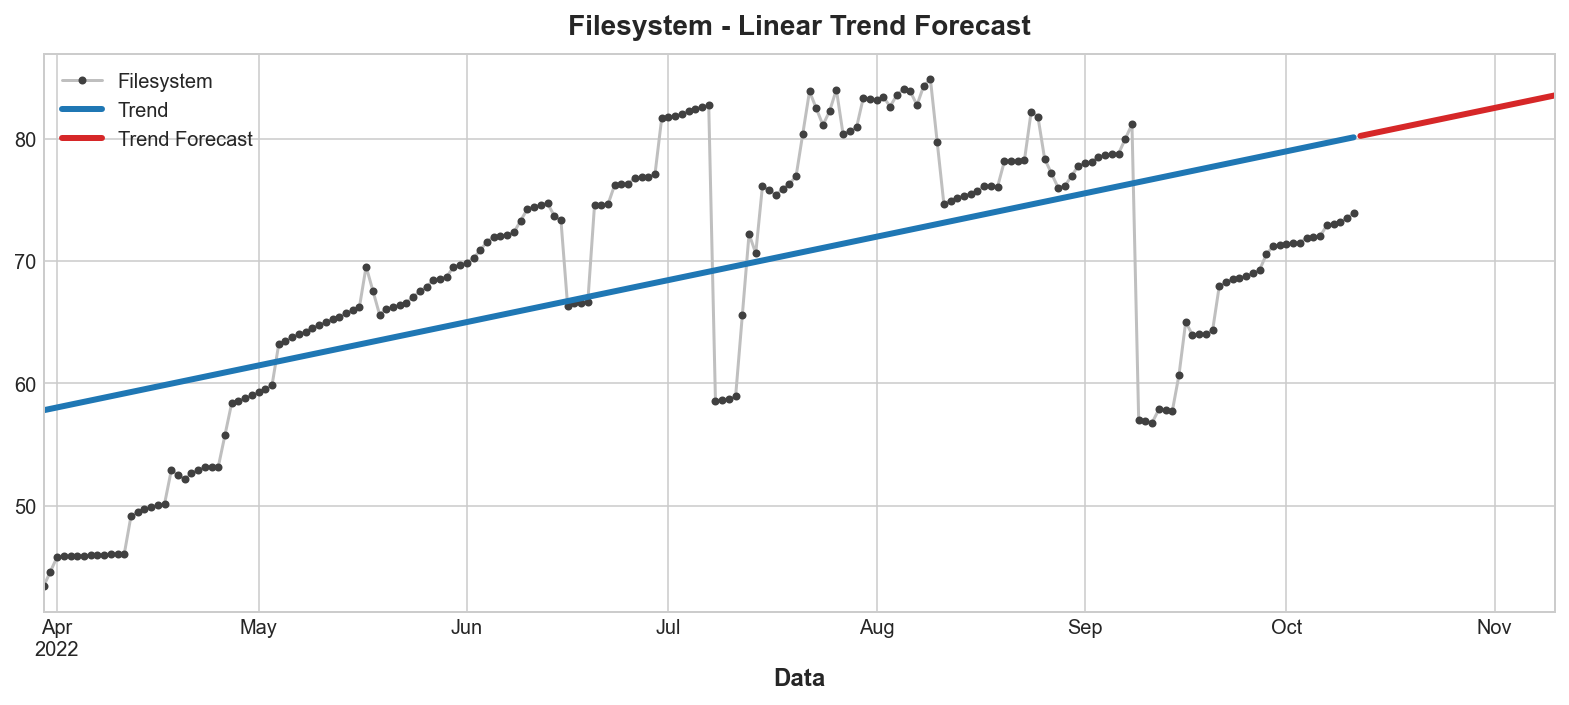

In [28]:
# Dados Parciais - mar/22

ax = df.plot(title="Filesystem - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

In [13]:
X = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X), index=X.index)

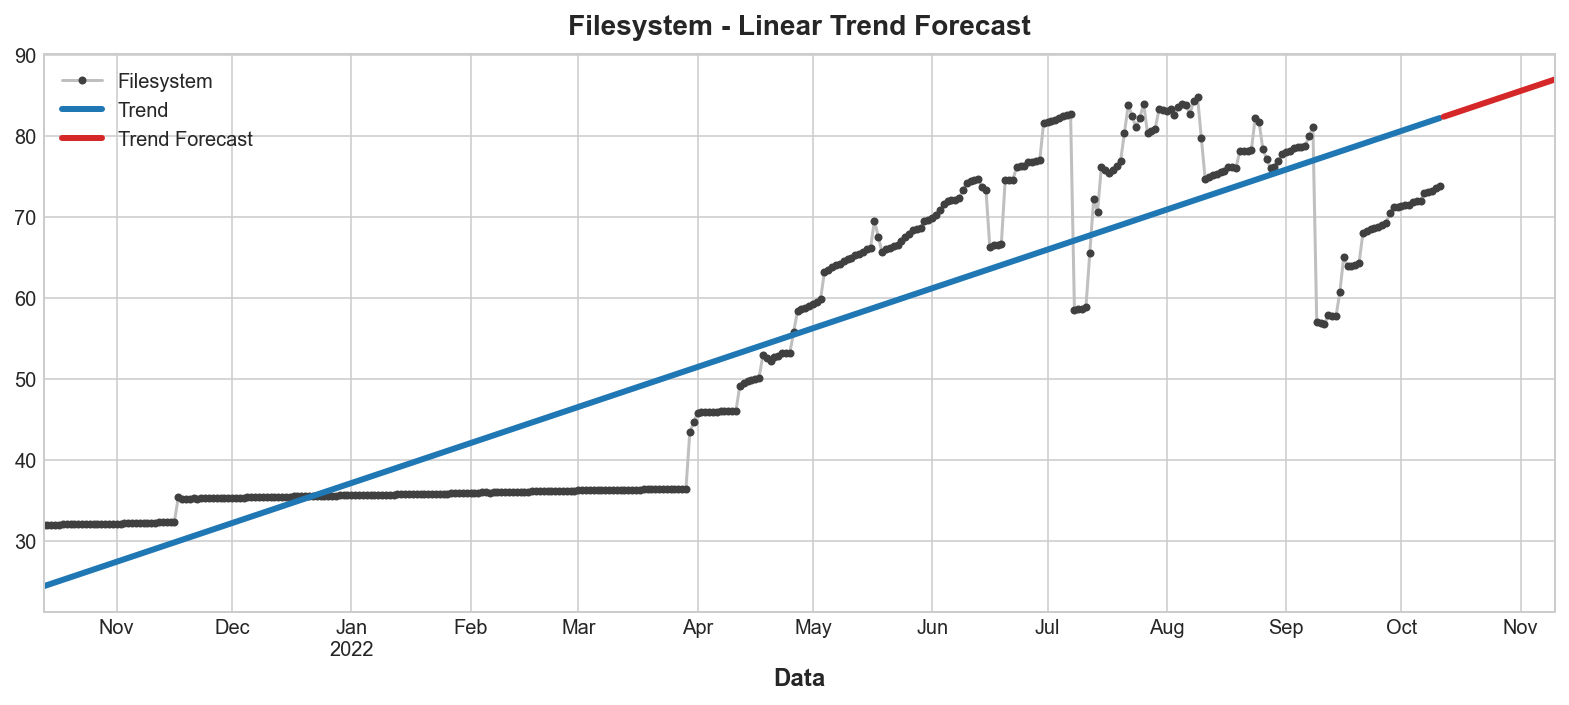

In [14]:
# Dados Completos - out/21

ax = df.plot(title="Filesystem - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

In [16]:
# Dados dos últimos 30 dias - de 20/set/22 até 11/out/22 

X = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X), index=X.index)

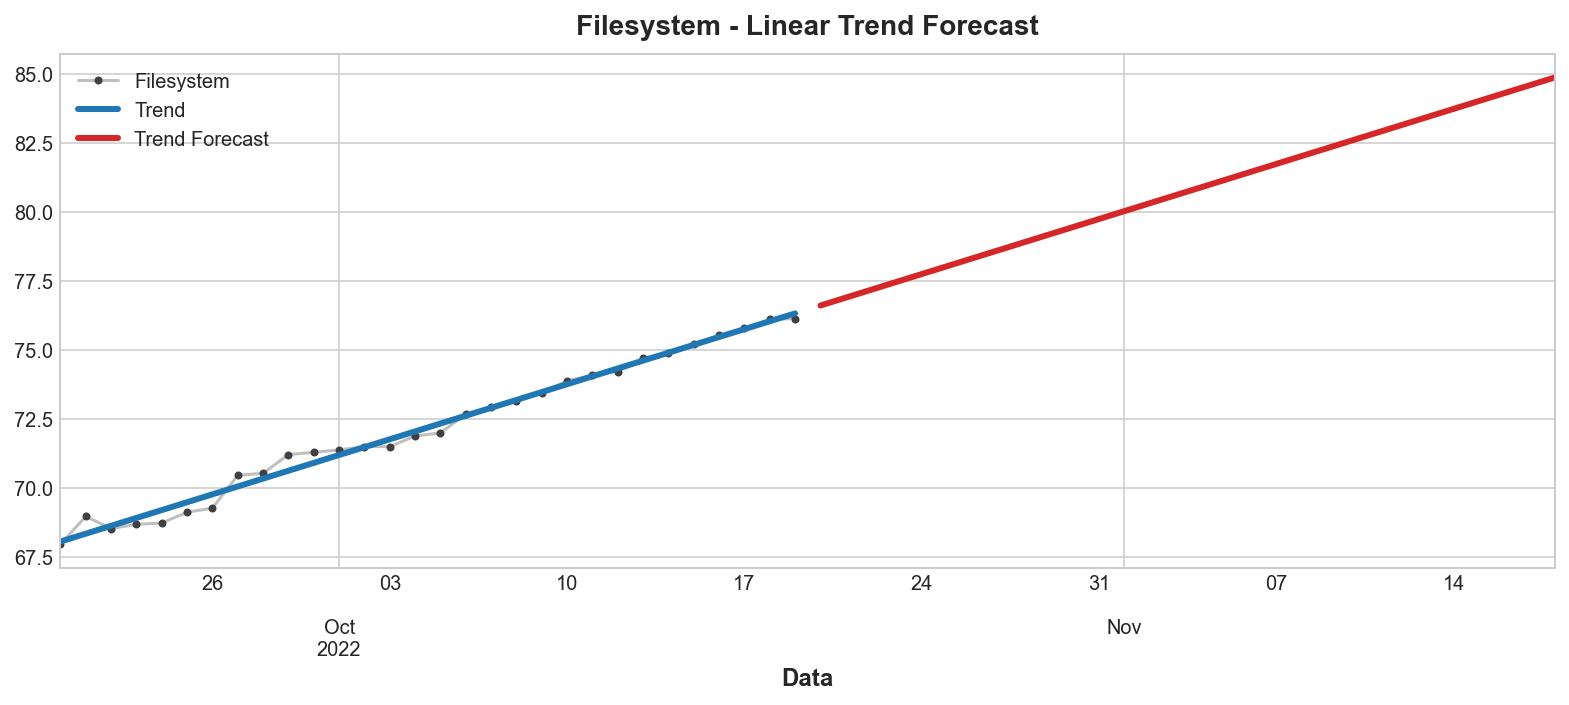

In [17]:
# Dados dos últimos 30 dias - de 20/set/22 até 11/out/22 

ax = df.plot(title="Filesystem - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

In [18]:
# Dados dos últimos 30 dias - de 20/set/22 até 11/out/22 

# estoura o limite de 80
y_fore.loc[y_fore.values >= 80].index[0]

Period('2022-11-01', 'D')

In [19]:
# Dados dos últimos 30 dias - de 20/set/22 até 11/out/22 

# Forecast
y_fore

2022-10-20    76.622736
2022-10-21    76.907901
2022-10-22    77.193067
2022-10-23    77.478233
2022-10-24    77.763399
2022-10-25    78.048564
2022-10-26    78.333730
2022-10-27    78.618896
2022-10-28    78.904062
2022-10-29    79.189227
2022-10-30    79.474393
2022-10-31    79.759559
2022-11-01    80.044725
2022-11-02    80.329890
2022-11-03    80.615056
2022-11-04    80.900222
2022-11-05    81.185387
2022-11-06    81.470553
2022-11-07    81.755719
2022-11-08    82.040885
2022-11-09    82.326050
2022-11-10    82.611216
2022-11-11    82.896382
2022-11-12    83.181548
2022-11-13    83.466713
2022-11-14    83.751879
2022-11-15    84.037045
2022-11-16    84.322211
2022-11-17    84.607376
2022-11-18    84.892542
Freq: D, dtype: float64

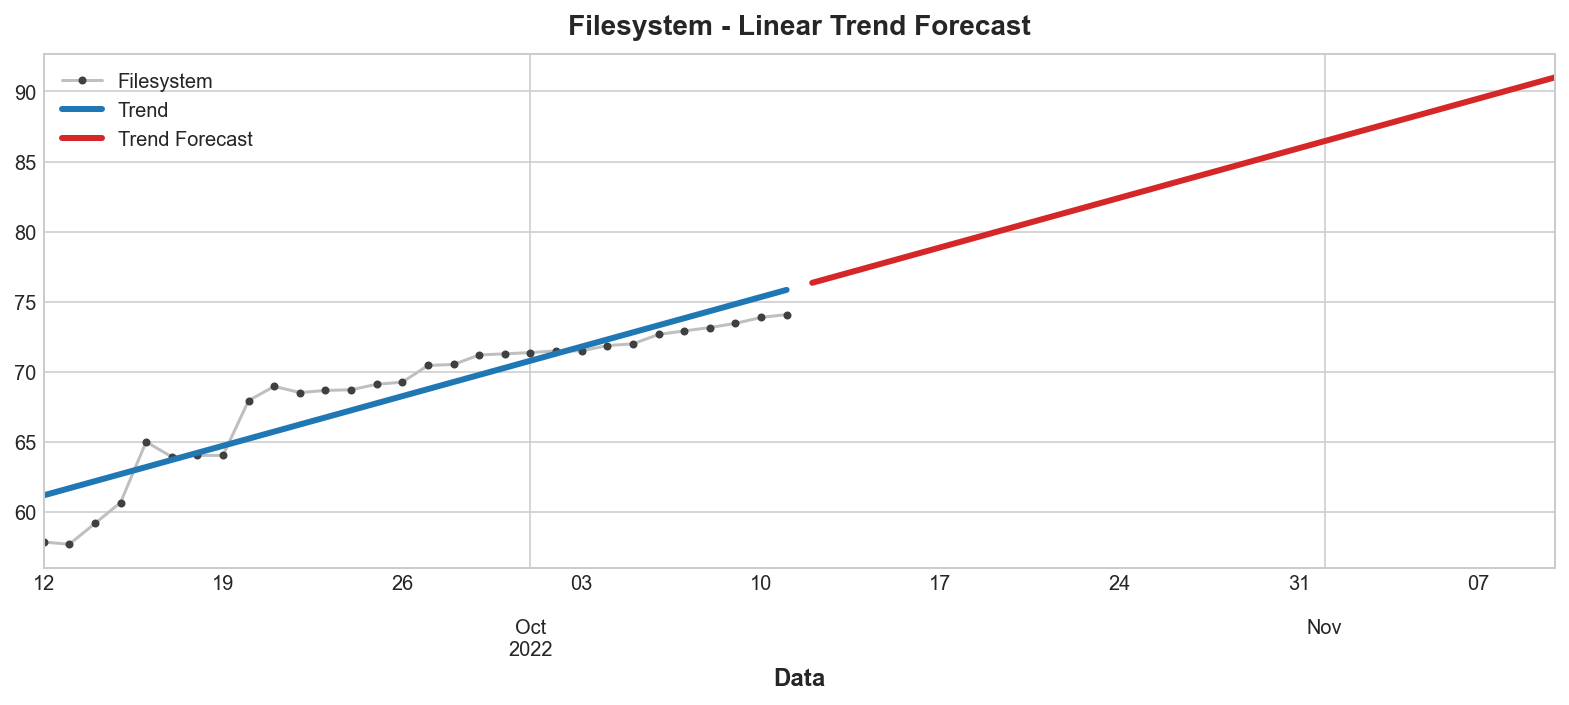

In [10]:
# Dados dos últimos 30 dias - set/22

ax = df.plot(title="Filesystem - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

In [11]:
# Dados dos últimos 30 dias - set/22

# estoura o limite de 80
y_fore.loc[y_fore.values >= 80].index[0]

Period('2022-10-20', 'D')

In [12]:
# Dados dos últimos 30 dias - set/22

# Forecast
y_fore

2022-10-12    76.360828
2022-10-13    76.865720
2022-10-14    77.370612
2022-10-15    77.875504
2022-10-16    78.380396
2022-10-17    78.885288
2022-10-18    79.390180
2022-10-19    79.895072
2022-10-20    80.399964
2022-10-21    80.904857
2022-10-22    81.409749
2022-10-23    81.914641
2022-10-24    82.419533
2022-10-25    82.924425
2022-10-26    83.429317
2022-10-27    83.934209
2022-10-28    84.439101
2022-10-29    84.943993
2022-10-30    85.448885
2022-10-31    85.953778
2022-11-01    86.458670
2022-11-02    86.963562
2022-11-03    87.468454
2022-11-04    87.973346
2022-11-05    88.478238
2022-11-06    88.983130
2022-11-07    89.488022
2022-11-08    89.992914
2022-11-09    90.497806
2022-11-10    91.002699
Freq: D, dtype: float64

In [29]:
# Dados Parciais - mar/22

# estoura o limite de 80
y_fore.loc[y_fore.values >= 80].index[0]

Period('2022-10-12', 'D')

In [30]:
# Dados Parciais - mar/22

# Forecast
y_fore

2022-10-12    80.219290
2022-10-13    80.333599
2022-10-14    80.447908
2022-10-15    80.562217
2022-10-16    80.676526
2022-10-17    80.790835
2022-10-18    80.905144
2022-10-19    81.019453
2022-10-20    81.133762
2022-10-21    81.248071
2022-10-22    81.362380
2022-10-23    81.476689
2022-10-24    81.590998
2022-10-25    81.705307
2022-10-26    81.819617
2022-10-27    81.933926
2022-10-28    82.048235
2022-10-29    82.162544
2022-10-30    82.276853
2022-10-31    82.391162
2022-11-01    82.505471
2022-11-02    82.619780
2022-11-03    82.734089
2022-11-04    82.848398
2022-11-05    82.962707
2022-11-06    83.077016
2022-11-07    83.191325
2022-11-08    83.305634
2022-11-09    83.419943
2022-11-10    83.534252
Freq: D, dtype: float64

In [15]:
# # Dados Completos - nov/21

# estoura o limite de 80
y_fore.loc[y_fore.values >= 80].index[0]

Period('2022-10-12', 'D')

In [16]:
# Dados Completos - nov/21

# Forecast
y_fore

2022-10-12    82.387074
2022-10-13    82.546343
2022-10-14    82.705611
2022-10-15    82.864880
2022-10-16    83.024149
2022-10-17    83.183417
2022-10-18    83.342686
2022-10-19    83.501955
2022-10-20    83.661223
2022-10-21    83.820492
2022-10-22    83.979761
2022-10-23    84.139030
2022-10-24    84.298298
2022-10-25    84.457567
2022-10-26    84.616836
2022-10-27    84.776104
2022-10-28    84.935373
2022-10-29    85.094642
2022-10-30    85.253910
2022-10-31    85.413179
2022-11-01    85.572448
2022-11-02    85.731717
2022-11-03    85.890985
2022-11-04    86.050254
2022-11-05    86.209523
2022-11-06    86.368791
2022-11-07    86.528060
2022-11-08    86.687329
2022-11-09    86.846597
2022-11-10    87.005866
Freq: D, dtype: float64